In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger

In [1]:
def preprocess_dataset(df):
    logger.info(f"Start preprocessing the dataframe with {df.shape[0]} samples...")

    # Delete all samples which have no/wrong bounding box information
    df_new = df[df["X-Max"] != 10000.0]

    # Delete all samples which have no/wrong bounding box information
    df_new = df[df["X-Max"] != 0.0]

    # Save the samples without/wrong bounding box information in a new df, as they will need to be added back later
    df_temp = df[(df["X-Max"] == 10000.0) | (df["X-Max"] == 0.0)]

    # Delete all samples which have less volume than 2,200,000 mm^3
    df_relevants = df_new[(df_new['volume'] > 2200000) & (df_new['volume'] < 800000000)].reset_index(drop=True)

    # Delete all samples where the parts are in the front area of the car
    df_relevants = df_relevants[df_relevants['X-Min'] > -30]

    # Delete all samples where the parts are in the center of the car
    df_relevants = df_relevants[~((df_relevants['X-Min'] > 200) & (df_relevants['X-Max'] < 2600) & (df_relevants['Y-Min'] > -700) & (df_relevants['Y-Max'] < 750))]

    df_for_plot = df_relevants.reset_index(drop=True)

    # concatenate the two data frames vertically
    df_relevants = pd.concat([df_relevants, df_temp])

    # reset the index of the merged data frame
    df_relevants = df_relevants.reset_index(drop=True)

    logger.success(f"The dataset is successfully preprocessed. The new dataset contains {df_relevants.shape[0]} samples")

    return df_relevants, df_for_plot

In [3]:
def transform_boundingbox(x_min, x_max, y_min, y_max, z_min, z_max, ox, oy, oz, xx, xy, xz, yx, yy, yz, zx, zy, zz):
    corners = np.array([[x_min, y_min, z_min],
                        [x_min, y_min, z_max],
                        [x_min, y_max, z_min],
                        [x_min, y_max, z_max],
                        [x_max, y_min, z_min],
                        [x_max, y_min, z_max],
                        [x_max, y_max, z_min],
                        [x_max, y_max, z_max]])
    
    rotation_matrix = np.array([[xx, xy, xz], [yx, yy, yz], [zx, zy, zz]])
    shift_vec = np.array([ox, oy, oz])
    rotated_corners = np.dot(corners, rotation_matrix) 
    transformed_corners = rotated_corners + shift_vec

    return transformed_corners    


In [4]:
def plot_bounding_box(ax, transformed_boundingbox, df, label_relevant):

    # Define the edges of the bounding box
    edges = [(0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)]

    # Plot the edges of the bounding box
    for edge in edges:
        if label_relevant == "Nein":
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], color='#999999', alpha=0.5, ms=10)
            relevant_count = 0
        else:
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], 'r-')    
            relevant_count = 1

 
    # Set the axis limits to the min and max values in the shifted_corners array
    ax.set_xlim3d([df['X-Min'].min(), df['X-Max'].max()])
    ax.set_ylim3d([df['Y-Min'].min(), df['Y-Max'].max()])
    ax.set_zlim3d([df['Z-Min'].min(), df['Z-Max'].max()])

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    return relevant_count


In [5]:
def plot_vehicle(df):
    fig = plt.figure(figsize=(14, 16), dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    # Iterate through the dataframe and plot each bounding box
    count_relevant_parts = 0
    count_all = 0

    for index, row in df.iterrows():  
            transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'],row['ox'],row['oy'],row['oz'],row['xx'],row['xy'],row['xz'],row['yx'],row['yy'],row['yz'],row['zx'],row['zy'],row['zz'])
            relevant = plot_bounding_box(ax, transformed_boundingbox, df, row["Relevant fuer Messung"])
            count_relevant_parts = count_relevant_parts + relevant
            count_all = count_all + 1

    print(f"{count_relevant_parts} of 34 relevant parts found")
    print(f"Still {count_all-count_relevant_parts} not relevant parts found")

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()    

In [6]:
def calculate_center_point(transf_bbox):
    sum_X = 0
    sum_Y = 0
    sum_Z = 0
    num_corners = len(transf_bbox)
    for xyz in transf_bbox:
        sum_X = sum_X + xyz[0]
        sum_Y = sum_Y + xyz[1]
        sum_Z = sum_Z + xyz[2]
    
    center_x = sum_X/num_corners
    center_y = sum_Y/num_corners
    center_z = sum_Z/num_corners

    return center_x, center_y, center_z



In [7]:
def calculate_lwh(transformed_boundingbox):
    x = []
    y = []
    z = []

    for xyz in transformed_boundingbox:
        x.append(xyz[0])  
        y.append(xyz[1])  
        z.append(xyz[2])   

    length = max(x) - min(x) 
    width = max(y) - min(y) 
    height = max(z) - min(z) 
    
    return length, width, height

In [8]:
def calculate_orientation(transformed_boundingbox):
    # Center the corners around the origin
    centered_corners = transformed_boundingbox - np.mean(transformed_boundingbox, axis=0) 

    # Perform SVD on the centered corners
    u, s, principal_axes = np.linalg.svd(centered_corners)

    # Convert the principal axes to Euler angles
    theta_x = np.arctan2(principal_axes[2, 1], principal_axes[2, 2])
    theta_y = np.arctan2(-principal_axes[2, 0], np.sqrt(principal_axes[2, 1]**2 + principal_axes[2, 2]**2))
    theta_z = np.arctan2(principal_axes[1, 0], principal_axes[0, 0])

    return theta_x, theta_y, theta_z

In [9]:
def add_new_features(df):
    for index, row in df.iterrows():  
        # Calculate and add new features to represent the bounding boxes
        transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'],row['ox'],row['oy'],row['oz'],row['xx'],row['xy'],row['xz'],row['yx'],row['yy'],row['yz'],row['zx'],row['zy'],row['zz'])
        center_x, center_y, center_z = calculate_center_point(transformed_boundingbox)
        length, width, height = calculate_lwh(transformed_boundingbox)
        theta_x, theta_y, theta_z = calculate_orientation(transformed_boundingbox)

        df.at[index, 'center_x'] = center_x
        df.at[index, 'center_y'] = center_y
        df.at[index, 'center_z'] = center_z
        df.at[index, 'length'] = length
        df.at[index, 'width'] = width
        df.at[index, 'height'] = height
        df.at[index, 'theta_x'] = theta_x
        df.at[index, 'theta_y'] = theta_y
        df.at[index, 'theta_z'] = theta_z

        # Calculate and add the volume as new feature 
        volume = length * width * height
        df.at[index, 'volume'] = volume

        # If weight is availabe, calculate and add the density as new feature 
        if pd.notnull(row['Wert']) and volume != 0:
            density = row['Wert'] / volume
            df.at[index, 'density'] = density
        
    return df

# Main

In [10]:
df = pd.read_excel("../data/labeled_data/G65_labeled.xlsx",index_col=0)

In [11]:
df.head()

,Sachnummer,Benennung (dt),X-Min,X-Max,Y-Min,Y-Max,Z-Min,Z-Max,Wert,Einheit,...,xy,xz,yx,yy,yz,zx,zy,zz,Relevant fuer Messung,Einheitsname
0,5A58C83,LI SCHRAUBLEISTE VERBINDUNG AUSSEN,393.345520,422.042664,-827.000000,-802.402954,-124.375999,67.050003,104.0,g,...,-2.432136e-07,0.000000,2.432136e-07,1.000000e+00,0.000000,0.000000e+00,0.0,1.000000e+00,Nein,NaN
1,5A58C84,RE SCHRAUBLEISTE VERBINDUNG AUSSEN,393.345520,422.042664,802.402954,827.000000,-124.375999,67.050003,104.0,g,...,3.443079e-07,0.000000,-3.443079e-07,1.000000e+00,0.000000,0.000000e+00,0.0,1.000000e+00,Nein,NaN
2,7057717,VERSTAERKUNG FKL SCHARNIER HINTEN,-24.951582,24.951582,-8.900000,29.883780,0.000000,10.750000,21.0,g,...,-4.544976e-16,0.416277,-4.162770e-01,-2.161757e-10,-0.909238,-8.998956e-11,1.0,-1.965560e-10,Nein,NaN
3,7057717,VERSTAERKUNG FKL SCHARNIER HINTEN,-24.951582,24.951582,-8.900000,29.883780,0.000000,10.750000,21.0,g,...,-2.822303e-16,-0.691627,6.916267e-01,1.099013e-15,-0.722255,1.936718e-15,-1.0,-1.182696e-15,Nein,NaN
4,7057717,VERSTAERKUNG FKL SCHARNIER HINTEN,-24.951582,24.951582,-8.900000,29.883780,0.000000,10.750000,21.0,g,...,2.873180e-11,0.412506,-4.125055e-01,2.142578e-10,-0.910955,-1.145561e-10,-1.0,-1.833283e-10,Nein,NaN


In [303]:
df_new_features = add_new_features(df)

In [304]:
df_preprocessed = preprocess_dataset(df_new_features)

2023-05-02 14:49:10.184 | INFO     | __main__:preprocess_dataset:2 - Start preprocessing the dataframe with 4585 samples...
2023-05-02 14:49:10.199 | SUCCESS  | __main__:preprocess_dataset:19 - The dataset is successfully preprocessed. The new dataset contains 512 samples


In [305]:
#df_preprocessed.to_excel("../data/G65_bounding_pp.xlsx")

34 of 34 relevant parts found
Still 478 not relevant parts found


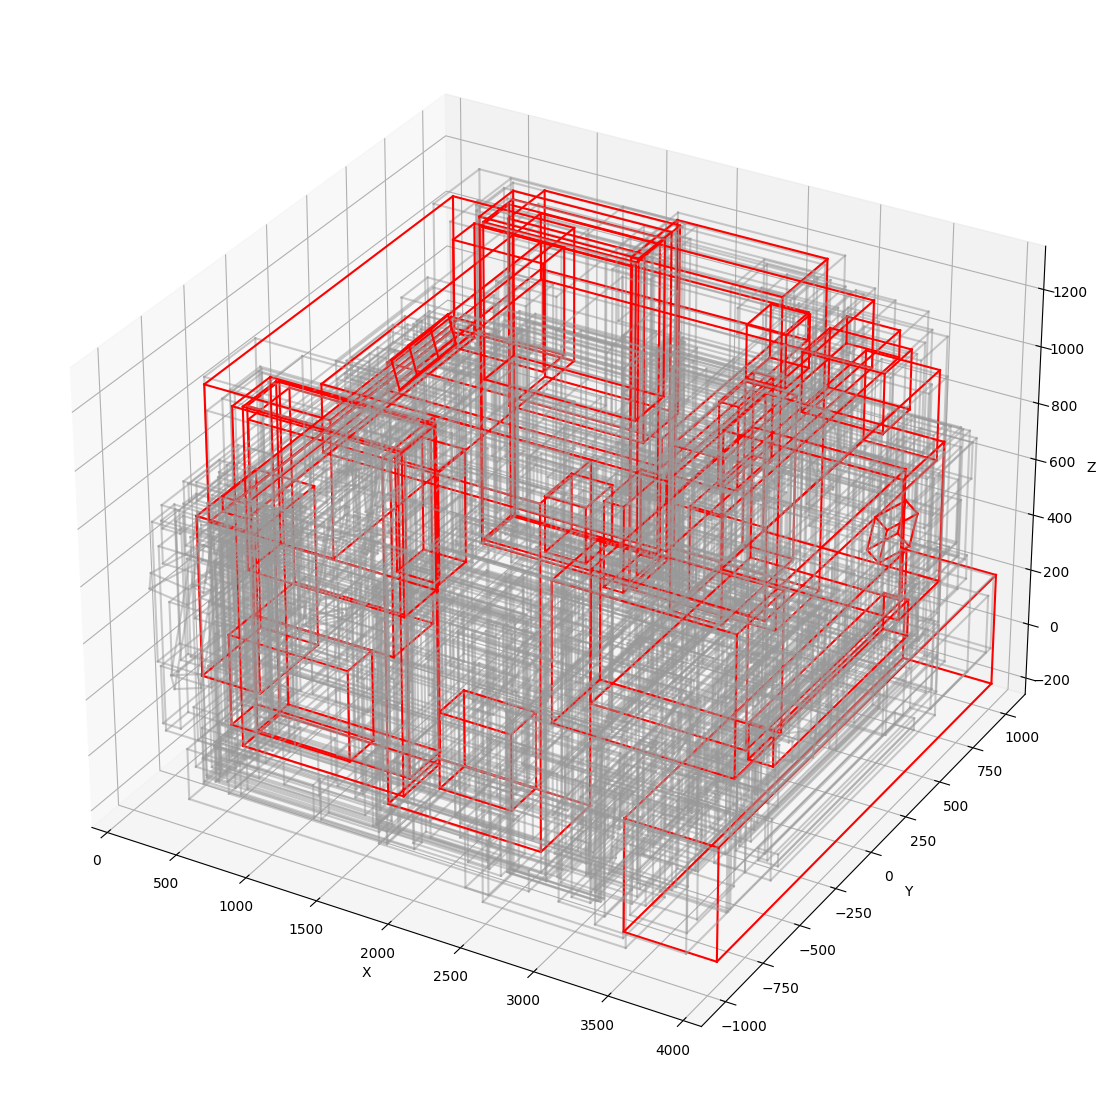

In [306]:
# Plot the bounding-box of a car with preprocessing
plot_vehicle(df_preprocessed)